In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
import pandas as pd
import scanpy as sc
import cellink as cl

/data/nasif12/home_if12/l_mai/.conda/envs/mm_scgenetics/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from cellink.tl._burden_testing import *

In [4]:
cell_type_col = "cell_label"

In [13]:
base_data_dir = Path("/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/")
input_dir = base_data_dir / "input_data"
output_dir = base_data_dir / "output"
## defining the path to the data
scdata_path = input_dir / "chr22_OneK1K_cohort_gene_expression_matrix_14_celltypes.h5ad.gz"
gdata_path = input_dir / "plink/"
dump_path = base_data_dir / "output/example_output"
vep_anno_file = input_dir /  "all_variants_annotated_fixed_ref_reversed_id.txt"
DNA_LM_file = input_dir/ "annotations/onek1k_inf_scores_upstream_model.tsv"
## defining target chromosome
target_chromosome = "22"

In [6]:
gdata = ad.read_h5ad(input_dir / "gdata_chr22_with_annos.h5ad")
gdata.obs = gdata.obs.set_index("id", drop = False)

In [7]:
gdata.varm['annotations_0']

Location  gnomADe_OTH_AF  Consequence_intergenic_variant  \
snp_id                                                                         
22_16849573_A_G  22:16849573             NaN                               1   
22_16849971_A_T  22:16849971             NaN                               1   
22_16850437_G_A  22:16850437             NaN                               1   
22_16851225_C_T  22:16851225             NaN                               1   
22_16851356_C_T  22:16851356             NaN                               1   
...                      ...             ...                             ...   
22_51202748_A_G  22:51202748             NaN                               0   
22_51208568_G_T  22:51208568             NaN                               0   
22_51211031_A_G  22:51211031             NaN                               0   
22_51213613_C_T  22:51213613             NaN                               0   
22_51216564_T_C  22:51216564             NaN                               0   

                 Consequence_start_lost  gnomADe_SAS_AF SOMATIC  CADD_PHRED  \
snp_id                                                                        
22_16849573_A_G                       0             NaN       -       8.747   
22_16849971_A_T                       0             NaN       -       8.843   
22_16850437_G_A                       0             NaN       -       8.063   
22_16851225_C_T                       0             NaN       -       8.324   
22_16851356_C_T                       0             NaN       -       8.148   
...                                 ...             ...     ...         ...   
22_51202748_A_G                       0             NaN       -       9.870   
22_51208568_G_T                       0             NaN       -       4.299   
22_51211031_A_G                       0             NaN       -       5.127   
22_51213613_C_T                       0             NaN       -       0.190   
22_51216564_T_C                       0             NaN       -       1.282   

                CLIN_SIG  gnomADe_EAS_AF Feature_type  ...  \
snp_id                                                 ...   
22_16849573_A_G        -             NaN            -  ...   
22_16849971_A_T        -             NaN            -  ...   
22_16850437_G_A        -             NaN            -  ...   
22_16851225_C_T        -             NaN            -  ...   
22_16851356_C_T        -             NaN            -  ...   
...                  ...             ...          ...  ...   
22_51202748_A_G        -             NaN   Transcript  ...   
22_51208568_G_T        -             NaN   Transcript  ...   
22_51211031_A_G        -             NaN   Transcript  ...   
22_51213613_C_T        -             NaN   Transcript  ...   
22_51216564_T_C        -             NaN   Transcript  ...   

                 Consequence_splice_acceptor_variant  \
snp_id                                                 
22_16849573_A_G                                    0   
22_16849971_A_T                                    0   
22_16850437_G_A                                    0   
22_16851225_C_T                                    0   
22_16851356_C_T                                    0   
...                                              ...   
22_51202748_A_G                                    0   
22_51208568_G_T                                    0   
22_51211031_A_G                                    0   
22_51213613_C_T                                    0   
22_51216564_T_C                                    0   

                Consequence_splice_donor_5th_base_variant  \
snp_id                                                      
22_16849573_A_G                                         0   
22_16849971_A_T                                         0   
22_16850437_G_A                                         0   
22_16851225_C_T                                         0   
22_16851356_C_T                                  

In [8]:
scdata = sc.read_h5ad(scdata_path)
scdata.var["chrom"] = "22" #current fix before chromosome is added to object 
scdata

AnnData object with n_obs × n_vars = 1272489 × 673
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'pool', 'individual', 'percent.mt', 'latent', 'nCount_SCT', 'nFeature_SCT', 'cell_type', 'cell_label', 'sex', 'age'
    var: 'GeneSymbol', 'features', 'chrom'

In [8]:
scdata.obs[cell_type_col].unique()

['CD4 ET', 'NK', 'CD4 NC', 'CD8 S100B', 'CD8 ET', ..., 'Mono C', 'Platelets', 'DC', 'Plasma', 'CD4 SOX4']
Length: 16
Categories (16, object): ['B IN', 'B Mem', 'CD4 ET', 'CD4 NC', ..., 'NK', 'NK R', 'Plasma', 'Platelets']

### process scdata by normalizing and log transforming

In [51]:
scdata_backup = scdata.copy()

In [37]:
scdata_backup.X

<1272489x673 sparse matrix of type '<class 'numpy.float64'>'
	with 28460678 stored elements in Compressed Sparse Row format>

In [21]:
scdata.X

<1272489x673 sparse matrix of type '<class 'numpy.float64'>'
	with 28460678 stored elements in Compressed Sparse Row format>

In [9]:
# perform normalization
sc.pp.normalize_total(scdata, target_sum=1e4)  # Normalize total counts per cell
# zeros because matrice is spare

/data/nasif12/home_if12/l_mai/.conda/envs/mm_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))


In [52]:
# check for difference
np.array(scdata_backup.X.sum(axis=1)).flatten()

array([57., 47., 38., ..., 70., 73., 58.])

In [54]:
np.array(scdata.X.sum(axis=1)).flatten()

array([10000., 10000., 10000., ..., 10000., 10000., 10000.])

In [55]:
scdata_backup_norm = scdata.copy()

In [10]:
# perform log scaling
sc.pp.log1p(scdata)  # Apply log-transform

In [58]:
data_changed = not np.array_equal(scdata_backup_norm.X.data, scdata.X.data)
print("Data changed after log-transform:", data_changed)

Data changed after log-transform: True


In [59]:
# check log transformation
print("Before log-transform:", scdata_backup_norm.X.data[:10])  # First 10 non-zero values
print("After log-transform:", scdata.X.data[:10]) 

Before log-transform: [175.43859649 175.43859649 175.43859649 526.31578947 175.43859649
 175.43859649 175.43859649 350.87719298 175.43859649 350.87719298]
After log-transform: [5.17297292 5.17297292 5.17297292 6.26779959 5.17297292 5.17297292
 5.17297292 5.86328223 5.17297292 5.86328223]


In [11]:
data = cl.DonorData(adata=scdata, gdata=gdata, donor_key_in_sc_adata="individual")

[2025-01-02 14:15:31,064] INFO:cellink._core.donordata: Keeping 981/1034 donors
[2025-01-02 14:15:31,065] INFO:cellink._core.donordata: Dropping 53/1034 donors from genetic data
[2025-01-02 14:15:31,065] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data


In [14]:
# ADD DNA_LM
def add_snp_id(DNA_LM):
    DNA_LM['snp_id'] = DNA_LM['Chromosome'] + "_" + DNA_LM['pos'].astype(str) + "_" + DNA_LM['ref'] + "_" + DNA_LM['alt']
    DNA_LM['snp_id'] = DNA_LM['snp_id'].str.replace('chr', '')
    
    # Set 'snap_id' as the index
    DNA_LM.set_index('snp_id', inplace=True)
    return DNA_LM

# Function to reverse ref/alt in DNA_LM where the reverse matches in data_gdata_varm
def reverse_and_update_snp_ids(gdata_df, dna_df):
    updated_index = []
    
    for snp_id in dna_df.index:
        if snp_id in gdata_df.index:
            updated_index.append(snp_id)
        else:
            chrom, pos, ref, alt = snp_id.split("_")
            reversed_snp_id = f"{chrom}_{pos}_{alt}_{ref}"  # Reverse ref and alt
            
            # Check if reversed_snp_id exists in data_df
            if reversed_snp_id in gdata_df.index:
                #print(f"Reversing {snp_id} to {reversed_snp_id}")
                updated_index.append(reversed_snp_id)
            else:
                print(f"Error, unknown snp_id {snp_id}")
                updated_index.append(snp_id)

            
    
    # Update DNA_LM's index
    dna_df.index = updated_index
    print("\nUpdated DNA_LM index:")
    print(dna_df.index)
    return dna_df

# Run the function
DNA_LM = pd.read_csv(DNA_LM_file,
            sep = '\t')
DNA_LM = add_snp_id(DNA_LM)
DNA_LM_chr22 = reverse_and_update_snp_ids(data.gdata.varm["annotations_0"], DNA_LM[DNA_LM["Chromosome"]=="chr22"])
#data.gdata.varm["annotations_0"]["DNA_LM_influence_score"] = DNA_LM_chr22["influence_score"]
data.gdata.varm["annotations_0"]["DNA_LM_influence_score"] = DNA_LM_chr22["influence_score"].reindex(
    data.gdata.varm["annotations_0"].index
)



Updated DNA_LM index:
Index(['22_16849573_A_G', '22_16849971_A_T', '22_16850437_G_A',
       '22_16851225_C_T', '22_16851356_C_T', '22_16851640_C_T',
       '22_16851673_A_G', '22_16851899_C_G', '22_16852312_G_A',
       '22_16852652_G_A',
       ...
       '22_51197602_T_A', '22_51198569_G_C', '22_51198868_T_C',
       '22_51198906_G_A', '22_51198998_C_A', '22_51202748_A_G',
       '22_51208568_G_T', '22_51211031_A_G', '22_51213613_C_T',
       '22_51216564_T_C'],
      dtype='object', length=96257)


/scratch/tmp/l_mai/ipykernel_1515893/809225327.py:43: ImplicitModificationWarning: Trying to modify attribute `.varm` of view, initializing view as actual.
  data.gdata.varm["annotations_0"]["DNA_LM_influence_score"] = DNA_LM_chr22["influence_score"].reindex(


In [15]:
# ADD MAF BETA 1.25
from scipy.stats import beta

In [16]:
print(data.gdata.var["maf"])
weighted_snp_maf = beta.pdf(data.gdata.var["maf"], 1, 25)
print(weighted_snp_maf)
data.gdata.varm["annotations_0"]["MAF_beta_1.25"] = weighted_snp_maf

snp_id
22_16849573_A_G    0.39991
22_16849971_A_T    0.39455
22_16850437_G_A    0.38920
22_16851225_C_T    0.39466
22_16851356_C_T    0.38772
                    ...   
22_51202748_A_G    0.06811
22_51208568_G_T    0.06645
22_51211031_A_G    0.06472
22_51213613_C_T    0.13375
22_51216564_T_C    0.13387
Name: maf, Length: 143083, dtype: float32
[1.18886710e-04 1.47169864e-04 1.81767677e-04 ... 5.01810308e+00
 7.96852377e-01 7.94207339e-01]


In [17]:
data.gdata.varm["annotations_0"]

Location  gnomADe_OTH_AF  Consequence_intergenic_variant  \
snp_id                                                                         
22_16849573_A_G  22:16849573             NaN                               1   
22_16849971_A_T  22:16849971             NaN                               1   
22_16850437_G_A  22:16850437             NaN                               1   
22_16851225_C_T  22:16851225             NaN                               1   
22_16851356_C_T  22:16851356             NaN                               1   
...                      ...             ...                             ...   
22_51202748_A_G  22:51202748             NaN                               0   
22_51208568_G_T  22:51208568             NaN                               0   
22_51211031_A_G  22:51211031             NaN                               0   
22_51213613_C_T  22:51213613             NaN                               0   
22_51216564_T_C  22:51216564             NaN                               0   

                 Consequence_start_lost  gnomADe_SAS_AF SOMATIC  CADD_PHRED  \
snp_id                                                                        
22_16849573_A_G                       0             NaN       -       8.747   
22_16849971_A_T                       0             NaN       -       8.843   
22_16850437_G_A                       0             NaN       -       8.063   
22_16851225_C_T                       0             NaN       -       8.324   
22_16851356_C_T                       0             NaN       -       8.148   
...                                 ...             ...     ...         ...   
22_51202748_A_G                       0             NaN       -       9.870   
22_51208568_G_T                       0             NaN       -       4.299   
22_51211031_A_G                       0             NaN       -       5.127   
22_51213613_C_T                       0             NaN       -       0.190   
22_51216564_T_C                       0             NaN       -       1.282   

                CLIN_SIG  gnomADe_EAS_AF Feature_type  ...  \
snp_id                                                 ...   
22_16849573_A_G        -             NaN            -  ...   
22_16849971_A_T        -             NaN            -  ...   
22_16850437_G_A        -             NaN            -  ...   
22_16851225_C_T        -             NaN            -  ...   
22_16851356_C_T        -             NaN            -  ...   
...                  ...             ...          ...  ...   
22_51202748_A_G        -             NaN   Transcript  ...   
22_51208568_G_T        -             NaN   Transcript  ...   
22_51211031_A_G        -             NaN   Transcript  ...   
22_51213613_C_T        -             NaN   Transcript  ...   
22_51216564_T_C        -             NaN   Transcript  ...   

                 Consequence_splice_donor_region_variant  \
snp_id                                                     
22_16849573_A_G                                        0   
22_16849971_A_T                                        0   
22_16850437_G_A                                        0   
22_16851225_C_T                                        0   
22_16851356_C_T                                        0   
...                                                  ...   
22_51202748_A_G                                        0   
22_51208568_G_T                                        0   
22_51211031_A_G                                        0   
22_51213613_C_T                                        0   
22_51216564_T_C                                        0   

                Consequence_splice_donor_variant  \
snp_id                                             
22_16849573_A_G                                0   
22_16849971_A_T                                0   
22_16850437_G_A                                0   
22_16851225_C_T                                0   
22_16851356_C_T                                0   

In [19]:
data.gdata.varm["annotations_0"].keys()

Index(['Location', 'gnomADe_OTH_AF', 'Consequence_intergenic_variant',
       'Consequence_start_lost', 'gnomADe_SAS_AF', 'SOMATIC', 'CADD_PHRED',
       'CLIN_SIG', 'gnomADe_EAS_AF', 'Feature_type', 'gnomADe_AF', 'PHENO',
       'Allele', 'Existing_variation', 'gnomADe_AMR_AF', 'gnomADe_FIN_AF',
       'gnomADe_AFR_AF', 'gnomADe_ASJ_AF', 'gnomADe_NFE_AF', 'CADD_RAW',
       'Gene', 'Feature', 'cDNA_position', 'CDS_position', 'Protein_position',
       'Amino_acids', 'Codons', 'IMPACT', 'DISTANCE', 'STRAND', 'FLAGS',
       'BIOTYPE', 'CANONICAL', 'ENSP', 'SIFT', 'PolyPhen', 'TSSDistance',
       'Consequence_3_prime_UTR_variant', 'Consequence_5_prime_UTR_variant',
       'Consequence_NMD_transcript_variant',
       'Consequence_coding_sequence_variant',
       'Consequence_downstream_gene_variant',
       'Consequence_incomplete_terminal_codon_variant',
       'Consequence_intron_variant', 'Consequence_mature_miRNA_variant',
       'Consequence_missense_variant',
       'Consequence_n

In [22]:
import pickle

In [27]:
# Save data object
with open(output_dir/"data_preprocessed.pkl", "wb") as f:
    pickle.dump(data, f)

print("AnnData object saved to data_preprocessed.pkl")

AnnData object saved to data_preprocessed.pkl


In [32]:
test_annotation = data.gdata.varm["annotations_0"].copy()

In [33]:
test_annotation

Location  gnomADe_OTH_AF  Consequence_intergenic_variant  \
snp_id                                                                         
22_16849573_A_G  22:16849573             NaN                               1   
22_16849971_A_T  22:16849971             NaN                               1   
22_16850437_G_A  22:16850437             NaN                               1   
22_16851225_C_T  22:16851225             NaN                               1   
22_16851356_C_T  22:16851356             NaN                               1   
...                      ...             ...                             ...   
22_51202748_A_G  22:51202748             NaN                               0   
22_51208568_G_T  22:51208568             NaN                               0   
22_51211031_A_G  22:51211031             NaN                               0   
22_51213613_C_T  22:51213613             NaN                               0   
22_51216564_T_C  22:51216564             NaN                               0   

                 Consequence_start_lost  gnomADe_SAS_AF SOMATIC  CADD_PHRED  \
snp_id                                                                        
22_16849573_A_G                       0             NaN       -       8.747   
22_16849971_A_T                       0             NaN       -       8.843   
22_16850437_G_A                       0             NaN       -       8.063   
22_16851225_C_T                       0             NaN       -       8.324   
22_16851356_C_T                       0             NaN       -       8.148   
...                                 ...             ...     ...         ...   
22_51202748_A_G                       0             NaN       -       9.870   
22_51208568_G_T                       0             NaN       -       4.299   
22_51211031_A_G                       0             NaN       -       5.127   
22_51213613_C_T                       0             NaN       -       0.190   
22_51216564_T_C                       0             NaN       -       1.282   

                CLIN_SIG  gnomADe_EAS_AF Feature_type  ...  \
snp_id                                                 ...   
22_16849573_A_G        -             NaN            -  ...   
22_16849971_A_T        -             NaN            -  ...   
22_16850437_G_A        -             NaN            -  ...   
22_16851225_C_T        -             NaN            -  ...   
22_16851356_C_T        -             NaN            -  ...   
...                  ...             ...          ...  ...   
22_51202748_A_G        -             NaN   Transcript  ...   
22_51208568_G_T        -             NaN   Transcript  ...   
22_51211031_A_G        -             NaN   Transcript  ...   
22_51213613_C_T        -             NaN   Transcript  ...   
22_51216564_T_C        -             NaN   Transcript  ...   

                 Consequence_splice_donor_region_variant  \
snp_id                                                     
22_16849573_A_G                                        0   
22_16849971_A_T                                        0   
22_16850437_G_A                                        0   
22_16851225_C_T                                        0   
22_16851356_C_T                                        0   
...                                                  ...   
22_51202748_A_G                                        0   
22_51208568_G_T                                        0   
22_51211031_A_G                                        0   
22_51213613_C_T                                        0   
22_51216564_T_C                                        0   

                Consequence_splice_donor_variant  \
snp_id                                             
22_16849573_A_G                                0   
22_16849971_A_T                                0   
22_16850437_G_A                                0   
22_16851225_C_T                                0   
22_16851356_C_T                                0   

In [34]:
test_annotation[['Chromosome', 'Position']] = test_annotation['Location'].str.split(':', expand=True)

In [36]:
test_annotation['Position'] = test_annotation['Position'].astype(int)

In [35]:
test_annotation

Location  gnomADe_OTH_AF  Consequence_intergenic_variant  \
snp_id                                                                         
22_16849573_A_G  22:16849573             NaN                               1   
22_16849971_A_T  22:16849971             NaN                               1   
22_16850437_G_A  22:16850437             NaN                               1   
22_16851225_C_T  22:16851225             NaN                               1   
22_16851356_C_T  22:16851356             NaN                               1   
...                      ...             ...                             ...   
22_51202748_A_G  22:51202748             NaN                               0   
22_51208568_G_T  22:51208568             NaN                               0   
22_51211031_A_G  22:51211031             NaN                               0   
22_51213613_C_T  22:51213613             NaN                               0   
22_51216564_T_C  22:51216564             NaN                               0   

                 Consequence_start_lost  gnomADe_SAS_AF SOMATIC  CADD_PHRED  \
snp_id                                                                        
22_16849573_A_G                       0             NaN       -       8.747   
22_16849971_A_T                       0             NaN       -       8.843   
22_16850437_G_A                       0             NaN       -       8.063   
22_16851225_C_T                       0             NaN       -       8.324   
22_16851356_C_T                       0             NaN       -       8.148   
...                                 ...             ...     ...         ...   
22_51202748_A_G                       0             NaN       -       9.870   
22_51208568_G_T                       0             NaN       -       4.299   
22_51211031_A_G                       0             NaN       -       5.127   
22_51213613_C_T                       0             NaN       -       0.190   
22_51216564_T_C                       0             NaN       -       1.282   

                CLIN_SIG  gnomADe_EAS_AF Feature_type  ...  \
snp_id                                                 ...   
22_16849573_A_G        -             NaN            -  ...   
22_16849971_A_T        -             NaN            -  ...   
22_16850437_G_A        -             NaN            -  ...   
22_16851225_C_T        -             NaN            -  ...   
22_16851356_C_T        -             NaN            -  ...   
...                  ...             ...          ...  ...   
22_51202748_A_G        -             NaN   Transcript  ...   
22_51208568_G_T        -             NaN   Transcript  ...   
22_51211031_A_G        -             NaN   Transcript  ...   
22_51213613_C_T        -             NaN   Transcript  ...   
22_51216564_T_C        -             NaN   Transcript  ...   

                 Consequence_splice_polypyrimidine_tract_variant  \
snp_id                                                             
22_16849573_A_G                                                0   
22_16849971_A_T                                                0   
22_16850437_G_A                                                0   
22_16851225_C_T                                                0   
22_16851356_C_T                                                0   
...                                                          ...   
22_51202748_A_G                                                0   
22_51208568_G_T                                                0   
22_51211031_A_G                                                0   
22_51213613_C_T                                                0   
22_51216564_T_C                                                0   

                Consequence_splice_region_variant Consequence_stop_gained  \
snp_id                                                                      
22_16849573_A_G                                 0                       0   
22_16849971_A_T             

### compute gene burdens

In [24]:
gdata = ad.read_h5ad(input_dir / "gdata_chr22_with_annos.h5ad")
gdata.obs = gdata.obs.set_index("id", drop = False)

In [25]:
gdata

AnnData object with n_obs × n_vars = 1034 × 143083
    obs: 'id'
    var: 'chrom', 'pos', 'a0', 'a1', 'AF', 'ER2', 'maf', 'R2', 'contig', 'id', 'id_mask', 'quality'
    varm: 'annotations_0', 'annotations_1', 'annotations_2', 'annotations_3', 'annotations_4', 'annotations_5', 'annotations_6', 'annotations_7'

In [26]:
plink_file = os.path.join(gdata_path, f"chr{target_chromosome}.dose.filtered.R2_0.8")
gdata = cl.io.read_plink(plink_file)

In [27]:
gdata

AnnData object with n_obs × n_vars = 1034 × 96257
    obs: 'family_id', 'member_id', 'paternal_id', 'maternal_id', 'sex', 'phenotype'
    var: 'chrom', 'pos', 'a0', 'a1', 'contig', 'id', 'maf'

In [28]:
# add annotations to gdata 
cl.tl.add_vep_annos_to_gdata(vep_anno_file, gdata,
                             cols_to_explode=["Consequence"],
                             cols_to_dummy=["Consequence"])
gdata

/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_annotate_snps_genotype_data.py:293: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  annos = pd.read_csv(


[2024-12-16 16:43:48,937] INFO:cellink.tl._annotate_snps_genotype_data: renaming id column #Uploaded_variation into snp_id
[2024-12-16 16:43:54,814] INFO:cellink.tl._annotate_snps_genotype_data: Subsetting annotations to variants that are in gdata
[2024-12-16 16:44:02,648] INFO:cellink.tl._annotate_snps_genotype_data: Index(['snp_id', 'Location', 'Allele', 'Gene', 'Feature', 'Feature_type',
       'Consequence', 'cDNA_position', 'CDS_position', 'Protein_position',
       'Amino_acids', 'Codons', 'Existing_variation', 'IMPACT', 'DISTANCE',
       'STRAND', 'FLAGS', 'BIOTYPE', 'CANONICAL', 'ENSP', 'SIFT', 'PolyPhen',
       'gnomADe_AF', 'gnomADe_AFR_AF', 'gnomADe_AMR_AF', 'gnomADe_ASJ_AF',
       'gnomADe_EAS_AF', 'gnomADe_FIN_AF', 'gnomADe_NFE_AF', 'gnomADe_OTH_AF',
       'gnomADe_SAS_AF', 'CLIN_SIG', 'SOMATIC', 'PHENO', 'CADD_PHRED',
       'CADD_RAW', 'TSSDistance'],
      dtype='object')
[2024-12-16 16:44:02,863] INFO:cellink.tl.utils: Exploding column Consequence
[2024-12-16 16:44

KeyboardInterrupt: 

In [12]:
from cellink.tl.utils import (
    _explode_columns,
    _get_vep_start_row,
    _add_dummy_cols,
    _flatten_single_value,
)
pd.read_csv(
        vep_anno_file, sep="\t", skiprows=_get_vep_start_row(vep_anno_file)
    )

/scratch/tmp/l_back/ipykernel_2639080/1924758431.py:7: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(


#Uploaded_variation     Location Allele             Gene  \
0              1_715265_T/C     1:715265      T  ENSG00000237491   
1              1_715265_T/C     1:715265      T  ENSG00000228327   
2              1_715367_G/A     1:715367      G  ENSG00000228327   
3              1_715367_G/A     1:715367      G  ENSG00000237491   
4              1_717485_A/C     1:717485      A  ENSG00000228327   
...                     ...          ...    ...              ...   
8579248     22_51211031_G/A  22:51211031      G  ENSG00000079974   
8579249     22_51213613_T/C  22:51213613      T  ENSG00000184319   
8579250     22_51213613_T/C  22:51213613      T  ENSG00000079974   
8579251     22_51216564_C/T  22:51216564      C  ENSG00000184319   
8579252     22_51216564_C/T  22:51216564      C  ENSG00000079974   

                 Feature Feature_type  \
0        ENST00000434264   Transcript   
1        ENST00000428504   Transcript   
2        ENST00000428504   Transcript   
3        ENST00000434264   Transcript   
4        ENST00000428504   Transcript   
...                  ...          ...   
8579248  ENST00000395593   Transcript   
8579249  ENST00000496652   Transcript   
8579250  ENST00000395593   Transcript   
8579251  ENST00000496652   Transcript   
8579252  ENST00000395593   Transcript   

                                          Consequence cDNA_position  \
0        intron_variant,non_coding_transcript_variant             -   
1                               upstream_gene_variant             -   
2                               upstream_gene_variant             -   
3        intron_variant,non_coding_transcript_variant             -   
4                               upstream_gene_variant             -   
...                                               ...           ...   
8579248                                intron_variant             -   
8579249  intron_variant,non_coding_transcript_variant             -   
8579250                                intron_variant             -   
8579251  intron_variant,non_coding_transcript_variant             -   
8579252                                intron_variant             -   

        CDS_position Protein_position  ... gnomADe_FIN_AF gnomADe_NFE_AF  \
0                  -                -  ...              -              -   
1                  -                -  ...              -              -   
2                  -                -  ...              -              -   
3                  -                -  ...              -              -   
4                  -                -  ...              -              -   
...              ...              ...  ...            ...            ...   
8579248            -                -  ...              -              -   
8579249            -                -  ...              -              -   
8579250            -                -  ...              -              -   
8579251            -                -  ...              -              -   
8579252            -                -  ...              -              -   

        gnomADe_OTH_AF gnomADe_SAS_AF CLIN_SIG SOMATIC PHENO CADD_PHRED  \
0                    -              -        -       -     -      1.266   
1                    -              -        -       -     -      1.266   
2                    -              -        -       -     -      2.493   
3                    -              -        -       -     -      2.493   
4                    -              -        -       -     -      0.400   
...                ...            ...      ...     ...   ...        ...   
8579248              -              -        -       -     -      5.127   
8579249              -              -        -       -     -      0.190   
8579250              -              -        -       -     -      0.190   
8579251              -              -        -       -     -      1.282   
8579252              -              -        -       -     -      1.282   

         CADD_RAW TSSDistance  

In [33]:
pd.read_csv(DNA_LM_file,
            sep = '\t')

Chromosome     Start       End Strand       pos ref alt  \
0             chr1    714263    716266      +    715265   C   T   
1             chr1    714365    716368      +    715367   A   G   
2             chr1    716483    718486      +    717485   C   A   
3             chr1    719379    721382      +    720381   G   T   
4             chr1    720288    722291      +    721290   G   C   
...            ...       ...       ...    ...       ...  ..  ..   
7406078      chr22  51201746  51203749      +  51202748   A   G   
7406079      chr22  51207566  51209569      +  51208568   G   T   
7406080      chr22  51210029  51212032      +  51211031   A   G   
7406081      chr22  51212611  51214614      +  51213613   C   T   
7406082      chr22  51215562  51217565      +  51216564   T   C   

         index_w_table    index  influence_score  
0                    0        0         0.013309  
1                    1        1         0.020517  
2                    2        2         0.027624  
3                    3        3         0.026201  
4                    4        4         0.022432  
...                ...      ...              ...  
7406078          96252  7406078         0.033990  
7406079          96253  7406079         0.031510  
7406080          96254  7406080         0.024377  
7406081          96255  7406081         0.024270  
7406082          96256  7406082         0.020555  

[7406083 rows x 10 columns]

In [ ]:
# create donor data 
data = cl.DonorData(adata=scdata, gdata=gdata, donor_key_in_sc_adata="individual")

In [28]:
gdata.varm["annotations_0"].columns

Index(['gnomADe_EAS_AF', 'Feature_type', 'Consequence_intergenic_variant',
       'PHENO', 'Consequence_start_lost', 'gnomADe_AMR_AF',
       'Existing_variation', 'CLIN_SIG', 'CADD_RAW', 'gnomADe_NFE_AF',
       'CADD_PHRED', 'gnomADe_ASJ_AF', 'gnomADe_OTH_AF', 'Allele', 'SOMATIC',
       'Location', 'gnomADe_SAS_AF', 'gnomADe_AF', 'gnomADe_AFR_AF',
       'gnomADe_FIN_AF', 'Gene', 'Feature', 'cDNA_position', 'CDS_position',
       'Protein_position', 'Amino_acids', 'Codons', 'IMPACT', 'DISTANCE',
       'STRAND', 'FLAGS', 'BIOTYPE', 'CANONICAL', 'ENSP', 'SIFT', 'PolyPhen',
       'TSSDistance', 'Consequence_3_prime_UTR_variant',
       'Consequence_5_prime_UTR_variant', 'Consequence_NMD_transcript_variant',
       'Consequence_coding_sequence_variant',
       'Consequence_downstream_gene_variant',
       'Consequence_incomplete_terminal_codon_variant',
       'Consequence_intron_variant', 'Consequence_mature_miRNA_variant',
       'Consequence_missense_variant',
       'Consequence_n

In [39]:
gdata.varm["annotations_0"]["DISTANCE"][~gdata.varm["annotations_0"]["DISTANCE"].isna()]

snp_id
22_16872281_C_G     668.0
22_16873251_A_C    1638.0
22_16873461_A_G    1848.0
22_16881807_A_C    4249.0
22_16885946_G_C     110.0
                    ...  
22_51195550_A_C    1689.0
22_51196164_T_A    2303.0
22_51196296_C_G    2435.0
22_51197602_A_T    3741.0
22_51198569_C_G    4708.0
Name: DISTANCE, Length: 18900, dtype: float64

In [40]:
all_burdens = compute_burdens(data, max_af=0.05, weight_cols=["DISTANCE", "CADD_PHRED"])
all_burdens.to_parquet("all_burdens_chr22.parquet")



00%|██████████| 673/673 [21:29<00:00,  1.92s/it]

In [43]:
type(data)

cellink._core.donordata.DonorData

In [7]:
import pickle

In [49]:
data_path = output_dir/"data.pkl"
with open(data_path, "wb") as file:
    pickle.dump(data, file)

In [8]:
with open("data.pkl", "rb") as file:
    data = pickle.load(file)

In [14]:
data.gdata.varm["annotations_0"]

gnomADe_EAS_AF Feature_type  Consequence_intergenic_variant  \
snp_id                                                                         
22_16849573_G_A             NaN            -                               1   
22_16849971_T_A             NaN            -                               1   
22_16850437_A_G             NaN            -                               1   
22_16851225_T_C             NaN            -                               1   
22_16851356_T_C             NaN            -                               1   
...                         ...          ...                             ...   
22_51202748_G_A             NaN   Transcript                               0   
22_51208568_T_G             NaN   Transcript                               0   
22_51211031_G_A             NaN   Transcript                               0   
22_51213613_T_C             NaN   Transcript                               0   
22_51216564_C_T             NaN   Transcript                               0   

                PHENO  Consequence_start_lost  gnomADe_AMR_AF  \
snp_id                                                          
22_16849573_G_A     -                       0             NaN   
22_16849971_T_A     -                       0             NaN   
22_16850437_A_G     -                       0             NaN   
22_16851225_T_C     -                       0             NaN   
22_16851356_T_C     -                       0             NaN   
...               ...                     ...             ...   
22_51202748_G_A     -                       0             NaN   
22_51208568_T_G     -                       0             NaN   
22_51211031_G_A     -                       0             NaN   
22_51213613_T_C     -                       0             NaN   
22_51216564_C_T     -                       0             NaN   

                Existing_variation CLIN_SIG  CADD_RAW  gnomADe_NFE_AF  ...  \
snp_id                                                                 ...   
22_16849573_G_A        rs112435201        -  0.433139             NaN  ...   
22_16849971_T_A          rs7287956        -  0.442607             NaN  ...   
22_16850437_A_G          rs5748209        -  0.369731             NaN  ...   
22_16851225_T_C          rs5746874        -  0.393139             NaN  ...   
22_16851356_T_C          rs5748581        -  0.377289             NaN  ...   
...                            ...      ...       ...             ...  ...   
22_51202748_G_A          rs9616963        -  0.550962             NaN  ...   
22_51208568_T_G        rs148425445        -  0.102244             NaN  ...   
22_51211031_G_A          rs9616968        -  0.153297             NaN  ...   
22_51213613_T_C         rs34726907        - -0.394121             NaN  ...   
22_51216564_C_T          rs9616970        - -0.113869             NaN  ...   

                 Consequence_non_coding_transcript_variant  \
snp_id                                                       
22_16849573_G_A                                          0   
22_16849971_T_A                                          0   
22_16850437_A_G                                          0   
22_16851225_T_C                                          0   
22_16851356_T_C                                          0   
...                                                    ...   
22_51202748_G_A                                          0   
22_51208568_T_G                                          0   
22_51211031_G_A                                          0   
22_51213613_T_C                                          0   
22_51216564_C_T                                          0   

                 Consequence_splice_acceptor_variant  \
snp_id                                                 
22_16849573_G_A                                    0   
22_16849971_T_A                                    0   
22_16850437_A_G                                    0   
22_16851225_T_C             

### ADD DNA_LM to annotations_0

In [43]:
def add_snp_id(DNA_LM):
    DNA_LM['snp_id'] = DNA_LM['Chromosome'] + "_" + DNA_LM['pos'].astype(str) + "_" + DNA_LM['ref'] + "_" + DNA_LM['alt']
    DNA_LM['snp_id'] = DNA_LM['snp_id'].str.replace('chr', '')
    
    # Set 'snap_id' as the index
    DNA_LM.set_index('snp_id', inplace=True)
    return DNA_LM

# Function to reverse ref/alt in DNA_LM where the reverse matches in data_gdata_varm
def reverse_and_update_snp_ids(gdata_df, dna_df):
    updated_index = []
    
    for snp_id in dna_df.index:
        if snp_id in gdata_df.index:
            updated_index.append(snp_id)
        else:
            chrom, pos, ref, alt = snp_id.split("_")
            reversed_snp_id = f"{chrom}_{pos}_{alt}_{ref}"  # Reverse ref and alt
            
            # Check if reversed_snp_id exists in data_df
            if reversed_snp_id in gdata_df.index:
                #print(f"Reversing {snp_id} to {reversed_snp_id}")
                updated_index.append(reversed_snp_id)
            else:
                print(f"Error, unknown snp_id {snp_id}")
                updated_index.append(snp_id)

            
    
    # Update DNA_LM's index
    dna_df.index = updated_index
    print("\nUpdated DNA_LM index:")
    print(dna_df.index)
    return dna_df

# Run the function
DNA_LM = pd.read_csv(DNA_LM_file,
            sep = '\t')
DNA_LM = add_snp_id(DNA_LM)
DNA_LM_chr22 = reverse_and_update_snp_ids(data.gdata.varm["annotations_0"], DNA_LM[DNA_LM["Chromosome"]=="chr22"])
data.gdata.varm["annotations_0"]["DNA_LM_influence_score"] = DNA_LM_chr22["influence_score"]
data.gdata.varm["annotations_0"]


Updated DNA_LM index:
Index(['22_16849573_G_A', '22_16849971_T_A', '22_16850437_A_G',
       '22_16851225_T_C', '22_16851356_T_C', '22_16851640_T_C',
       '22_16851673_G_A', '22_16851899_G_C', '22_16852312_A_G',
       '22_16852652_A_G',
       ...
       '22_51197602_A_T', '22_51198569_C_G', '22_51198868_C_T',
       '22_51198906_A_G', '22_51198998_A_C', '22_51202748_G_A',
       '22_51208568_T_G', '22_51211031_G_A', '22_51213613_T_C',
       '22_51216564_C_T'],
      dtype='object', length=96257)


gnomADe_EAS_AF Feature_type  Consequence_intergenic_variant  \
snp_id                                                                         
22_16849573_G_A             NaN            -                               1   
22_16849971_T_A             NaN            -                               1   
22_16850437_A_G             NaN            -                               1   
22_16851225_T_C             NaN            -                               1   
22_16851356_T_C             NaN            -                               1   
...                         ...          ...                             ...   
22_51202748_G_A             NaN   Transcript                               0   
22_51208568_T_G             NaN   Transcript                               0   
22_51211031_G_A             NaN   Transcript                               0   
22_51213613_T_C             NaN   Transcript                               0   
22_51216564_C_T             NaN   Transcript                               0   

                PHENO  Consequence_start_lost  gnomADe_AMR_AF  \
snp_id                                                          
22_16849573_G_A     -                       0             NaN   
22_16849971_T_A     -                       0             NaN   
22_16850437_A_G     -                       0             NaN   
22_16851225_T_C     -                       0             NaN   
22_16851356_T_C     -                       0             NaN   
...               ...                     ...             ...   
22_51202748_G_A     -                       0             NaN   
22_51208568_T_G     -                       0             NaN   
22_51211031_G_A     -                       0             NaN   
22_51213613_T_C     -                       0             NaN   
22_51216564_C_T     -                       0             NaN   

                Existing_variation CLIN_SIG  CADD_RAW  gnomADe_NFE_AF  ...  \
snp_id                                                                 ...   
22_16849573_G_A        rs112435201        -  0.433139             NaN  ...   
22_16849971_T_A          rs7287956        -  0.442607             NaN  ...   
22_16850437_A_G          rs5748209        -  0.369731             NaN  ...   
22_16851225_T_C          rs5746874        -  0.393139             NaN  ...   
22_16851356_T_C          rs5748581        -  0.377289             NaN  ...   
...                            ...      ...       ...             ...  ...   
22_51202748_G_A          rs9616963        -  0.550962             NaN  ...   
22_51208568_T_G        rs148425445        -  0.102244             NaN  ...   
22_51211031_G_A          rs9616968        -  0.153297             NaN  ...   
22_51213613_T_C         rs34726907        - -0.394121             NaN  ...   
22_51216564_C_T          rs9616970        - -0.113869             NaN  ...   

                 Consequence_splice_acceptor_variant  \
snp_id                                                 
22_16849573_G_A                                    0   
22_16849971_T_A                                    0   
22_16850437_A_G                                    0   
22_16851225_T_C                                    0   
22_16851356_T_C                                    0   
...                                              ...   
22_51202748_G_A                                    0   
22_51208568_T_G                                    0   
22_51211031_G_A                                    0   
22_51213613_T_C                                    0   
22_51216564_C_T                                    0   

                 Consequence_splice_donor_5th_base_variant  \
snp_id                                                       
22_16849573_G_A                                          0   
22_16849971_T_A                                          0   
22_16850437_A_G                                          0   
22_16851225_T_C                                          0   
22_16851356_T_

## Add MAF beta 1.25

In [84]:
# get MAF
data.gdata.var["maf"]

snp_id
22_16849573_G_A    0.383462
22_16849971_T_A    0.383462
22_16850437_A_G    0.383462
22_16851225_T_C    0.383462
22_16851356_T_C    0.383462
                     ...   
22_51202748_G_A    0.067698
22_51208568_T_G    0.067215
22_51211031_G_A    0.064797
22_51213613_T_C    0.132495
22_51216564_C_T    0.132495
Name: maf, Length: 96257, dtype: float64

In [110]:
from scipy.stats import beta
print(data.gdata.var["maf"])
weighted_snp_maf = beta.pdf(data.gdata.var["maf"], 1, 25)
print(weighted_snp_maf)

snp_id
22_16849573_G_A    0.383462
22_16849971_T_A    0.383462
22_16850437_A_G    0.383462
22_16851225_T_C    0.383462
22_16851356_T_C    0.383462
                     ...   
22_51202748_G_A    0.067698
22_51208568_T_G    0.067215
22_51211031_G_A    0.064797
22_51213613_T_C    0.132495
22_51216564_C_T    0.132495
Name: maf, Length: 96257, dtype: float64
[2.27494875e-04 2.27494875e-04 2.27494875e-04 ... 5.00820914e+00
 8.25022346e-01 8.25022346e-01]


In [92]:
data.gdata.varm["annotations_0"]["MAF_beta_1.25"] = weighted_snp_maf
data.gdata.varm["annotations_0"]

gnomADe_EAS_AF Feature_type  Consequence_intergenic_variant  \
snp_id                                                                         
22_16849573_G_A             NaN            -                               1   
22_16849971_T_A             NaN            -                               1   
22_16850437_A_G             NaN            -                               1   
22_16851225_T_C             NaN            -                               1   
22_16851356_T_C             NaN            -                               1   
...                         ...          ...                             ...   
22_51202748_G_A             NaN   Transcript                               0   
22_51208568_T_G             NaN   Transcript                               0   
22_51211031_G_A             NaN   Transcript                               0   
22_51213613_T_C             NaN   Transcript                               0   
22_51216564_C_T             NaN   Transcript                               0   

                PHENO  Consequence_start_lost  gnomADe_AMR_AF  \
snp_id                                                          
22_16849573_G_A     -                       0             NaN   
22_16849971_T_A     -                       0             NaN   
22_16850437_A_G     -                       0             NaN   
22_16851225_T_C     -                       0             NaN   
22_16851356_T_C     -                       0             NaN   
...               ...                     ...             ...   
22_51202748_G_A     -                       0             NaN   
22_51208568_T_G     -                       0             NaN   
22_51211031_G_A     -                       0             NaN   
22_51213613_T_C     -                       0             NaN   
22_51216564_C_T     -                       0             NaN   

                Existing_variation CLIN_SIG  CADD_RAW  gnomADe_NFE_AF  ...  \
snp_id                                                                 ...   
22_16849573_G_A        rs112435201        -  0.433139             NaN  ...   
22_16849971_T_A          rs7287956        -  0.442607             NaN  ...   
22_16850437_A_G          rs5748209        -  0.369731             NaN  ...   
22_16851225_T_C          rs5746874        -  0.393139             NaN  ...   
22_16851356_T_C          rs5748581        -  0.377289             NaN  ...   
...                            ...      ...       ...             ...  ...   
22_51202748_G_A          rs9616963        -  0.550962             NaN  ...   
22_51208568_T_G        rs148425445        -  0.102244             NaN  ...   
22_51211031_G_A          rs9616968        -  0.153297             NaN  ...   
22_51213613_T_C         rs34726907        - -0.394121             NaN  ...   
22_51216564_C_T          rs9616970        - -0.113869             NaN  ...   

                 Consequence_splice_donor_5th_base_variant  \
snp_id                                                       
22_16849573_G_A                                          0   
22_16849971_T_A                                          0   
22_16850437_A_G                                          0   
22_16851225_T_C                                          0   
22_16851356_T_C                                          0   
...                                                    ...   
22_51202748_G_A                                          0   
22_51208568_T_G                                          0   
22_51211031_G_A                                          0   
22_51213613_T_C                                          0   
22_51216564_C_T                                          0   

                 Consequence_splice_donor_region_variant  \
snp_id                                                     
22_16849573_G_A                                        0   
22_16849971_T_A                                        0   
22_16850437_A_G                                        0   
22_16851

In [94]:
all_burdens = compute_burdens(data, max_af=0.05, weight_cols=["DISTANCE", "CADD_PHRED", "DNA_LM_influence_score", "MAF_beta_1.25"])
burdens_path = output_dir/"all_burdens_chr22_with_DNA_LM_and_MAF.parquet"
all_burdens.to_parquet(burdens_path)



00%|██████████| 673/673 [24:18<00:00,  2.17s/it]

In [10]:
burdens_path = output_dir/"all_burdens_chr22_with_DNA_LM_and_MAF.parquet"
all_burdens = pd.read_parquet(burdens_path)

### run association testing

In [41]:
precomputed_burdens = pd.read_parquet(input_dir/ "all_burdens_chr22.parquet")

In [17]:
# target_genes = precomputed_burdens["Geneid"].unique()[:10]
# target_genes

In [22]:
target_cell_type = "CD4 ET"

burden_test(
            donor_data = data,
            gene_burdens = all_burdens,
            target_cell_type = target_cell_type,
            target_chromosome = target_chromosome,
            dump_dir = dump_path,
            # target_genes = target_genes,
            transforms_seq = None #TODO comment this back in to quantile transform phenotype. Commented out to make testing faster
)

/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:224: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:224: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is d

[2024-12-19 14:44:50,654] INFO:cellink._core.donordata: Keeping 981/981 donors
[2024-12-19 14:44:50,655] INFO:cellink._core.donordata: Dropping 0/981 donors from genetic data
[2024-12-19 14:44:50,655] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data
[2024-12-19 14:44:50,660] INFO:cellink.tl._burden_testing: transforming phenotype
[2024-12-19 14:44:50,663] INFO:cellink.tl._burden_testing: `target_genes` not defined, running the EQTL agains all the 435 genes for current combination of target_cell_type='CD4 ET', target_chromosome='22'.


/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:224: ImplicitModificationWarning: Setting element `.layers['transformed_mean']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:234: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: Runt

[2024-12-19 14:45:11,980] WARNING:cellink.tl._burden_testing: dump_dir=PosixPath('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/example_output') file_prefix='burden'


(        burden_gene      target_gene             burden_type    pvalue  \
 0   ENSG00000100181  ENSG00000100181                DISTANCE  0.548514   
 1   ENSG00000100181  ENSG00000100181              CADD_PHRED  0.248772   
 2   ENSG00000100181  ENSG00000100181  DNA_LM_influence_score  0.182687   
 3   ENSG00000100181  ENSG00000100181           MAF_beta_1.25  0.235187   
 0   ENSG00000237438  ENSG00000237438                DISTANCE  0.898362   
 ..              ...              ...                     ...       ...   
 3   ENSG00000100299  ENSG00000100299           MAF_beta_1.25  0.425463   
 0   ENSG00000079974  ENSG00000079974                DISTANCE  1.000000   
 1   ENSG00000079974  ENSG00000079974              CADD_PHRED  1.000000   
 2   ENSG00000079974  ENSG00000079974  DNA_LM_influence_score  1.000000   
 3   ENSG00000079974  ENSG00000079974           MAF_beta_1.25  1.000000   
 
         beta cell_type chrom  
 0  -0.000514    CD4 ET    22  
 1  -0.000993    CD4 ET    22  
 2

#  From here on old code!!! 

#### Association testing for all cell types 

In [57]:
cell_types = data.adata.obs["cell_label"].unique()
cell_types

['CD8 ET', 'CD8 NC', 'CD4 NC', 'Mono C', 'NK', ..., 'DC', 'NK R', 'Platelets', 'CD4 SOX4', 'Erythrocytes']
Length: 16
Categories (16, object): ['B IN', 'B Mem', 'CD4 ET', 'CD4 NC', ..., 'NK', 'NK R', 'Plasma', 'Platelets']

In [96]:
all_res = []
#cell_types = ["CD4 NC", "B IN", "B Mem"]
for target_cell_type in cell_types:
    print(target_cell_type)
    this_res = burden_test(
            donor_data = data,
            gene_burdens = all_burdens,
            target_cell_type = target_cell_type,
            target_chromosome = target_chromosome,
            dump_dir = dump_path,
            # target_genes = target_genes,
            transforms_seq = None #TODO comment this back in to quantile transform phenotype. Commented out to make testing faster
            )
    all_res.append(this_res[0])
all_res = pd.concat(all_res)


CD8 ET


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


[2024-12-17 15:09:47,654] INFO:cellink._core.donordata: Keeping 981/981 donors
[2024-12-17 15:09:47,655] INFO:cellink._core.donordata: Dropping 0/981 donors from genetic data
[2024-12-17 15:09:47,655] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data
[2024-12-17 15:09:47,662] INFO:cellink.tl._burden_testing: transforming phenotype
[2024-12-17 15:09:47,667] INFO:cellink.tl._burden_testing: `target_genes` not defined, running the EQTL agains all the 478 genes for current combination of target_cell_type='CD8 ET', target_chromosome='22'.


/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:166: ImplicitModificationWarning: Setting element `.layers['transformed_mean']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:176: ImplicitModificationWarning: Trying to modify attrib

[2024-12-17 15:10:07,588] WARNING:cellink.tl._burden_testing: dump_dir=PosixPath('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/example_output') file_prefix='burden'


CD8 NC


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


[2024-12-17 15:10:10,317] INFO:cellink._core.donordata: Keeping 981/981 donors
[2024-12-17 15:10:10,318] INFO:cellink._core.donordata: Dropping 0/981 donors from genetic data
[2024-12-17 15:10:10,318] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data
[2024-12-17 15:10:10,324] INFO:cellink.tl._burden_testing: transforming phenotype
[2024-12-17 15:10:10,329] INFO:cellink.tl._burden_testing: `target_genes` not defined, running the EQTL agains all the 468 genes for current combination of target_cell_type='CD8 NC', target_chromosome='22'.


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:166: ImplicitModificationWarning: Setting element `.layers['transformed_mean']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:176: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/da

[2024-12-17 15:10:28,021] WARNING:cellink.tl._burden_testing: dump_dir=PosixPath('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/example_output') file_prefix='burden'


CD4 NC


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is d

[2024-12-17 15:10:35,364] INFO:cellink._core.donordata: Keeping 981/981 donors
[2024-12-17 15:10:35,365] INFO:cellink._core.donordata: Dropping 0/981 donors from genetic data
[2024-12-17 15:10:35,366] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data
[2024-12-17 15:10:35,379] INFO:cellink.tl._burden_testing: transforming phenotype
[2024-12-17 15:10:35,385] INFO:cellink.tl._burden_testing: `target_genes` not defined, running the EQTL agains all the 504 genes for current combination of target_cell_type='CD4 NC', target_chromosome='22'.


/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:166: ImplicitModificationWarning: Setting element `.layers['transformed_mean']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:176: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: Runt

[2024-12-17 15:10:57,553] WARNING:cellink.tl._burden_testing: dump_dir=PosixPath('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/example_output') file_prefix='burden'


Mono C


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is d

[2024-12-17 15:10:58,567] INFO:cellink._core.donordata: Keeping 968/981 donors
[2024-12-17 15:10:58,568] INFO:cellink._core.donordata: Dropping 13/981 donors from genetic data
[2024-12-17 15:10:58,568] INFO:cellink._core.donordata: Dropping 0/968 donors from single-cell data
[2024-12-17 15:10:58,573] INFO:cellink.tl._burden_testing: transforming phenotype
[2024-12-17 15:10:58,578] INFO:cellink.tl._burden_testing: `target_genes` not defined, running the EQTL agains all the 420 genes for current combination of target_cell_type='Mono C', target_chromosome='22'.


/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:166: ImplicitModificationWarning: Setting element `.layers['transformed_mean']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:176: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: Runt

[2024-12-17 15:11:13,443] WARNING:cellink.tl._burden_testing: dump_dir=PosixPath('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/example_output') file_prefix='burden'


NK


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


[2024-12-17 15:11:16,184] INFO:cellink._core.donordata: Keeping 981/981 donors
[2024-12-17 15:11:16,184] INFO:cellink._core.donordata: Dropping 0/981 donors from genetic data
[2024-12-17 15:11:16,185] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data
[2024-12-17 15:11:16,191] INFO:cellink.tl._burden_testing: transforming phenotype
[2024-12-17 15:11:16,196] INFO:cellink.tl._burden_testing: `target_genes` not defined, running the EQTL agains all the 478 genes for current combination of target_cell_type='NK', target_chromosome='22'.


/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:166: ImplicitModificationWarning: Setting element `.layers['transformed_mean']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:176: ImplicitModificationWarning: Trying to modify attrib

[2024-12-17 15:11:36,471] WARNING:cellink.tl._burden_testing: dump_dir=PosixPath('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/example_output') file_prefix='burden'
B IN


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


[2024-12-17 15:11:37,896] INFO:cellink._core.donordata: Keeping 981/981 donors
[2024-12-17 15:11:37,897] INFO:cellink._core.donordata: Dropping 0/981 donors from genetic data
[2024-12-17 15:11:37,897] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data
[2024-12-17 15:11:37,902] INFO:cellink.tl._burden_testing: transforming phenotype
[2024-12-17 15:11:37,907] INFO:cellink.tl._burden_testing: `target_genes` not defined, running the EQTL agains all the 450 genes for current combination of target_cell_type='B IN', target_chromosome='22'.


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:166: ImplicitModificationWarning: Setting element `.layers['transformed_mean']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:176: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/da

[2024-12-17 15:11:55,451] WARNING:cellink.tl._burden_testing: dump_dir=PosixPath('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/example_output') file_prefix='burden'


CD4 ET


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is d

[2024-12-17 15:11:56,989] INFO:cellink._core.donordata: Keeping 981/981 donors
[2024-12-17 15:11:56,990] INFO:cellink._core.donordata: Dropping 0/981 donors from genetic data
[2024-12-17 15:11:56,991] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data
[2024-12-17 15:11:56,995] INFO:cellink.tl._burden_testing: transforming phenotype
[2024-12-17 15:11:57,000] INFO:cellink.tl._burden_testing: `target_genes` not defined, running the EQTL agains all the 435 genes for current combination of target_cell_type='CD4 ET', target_chromosome='22'.


/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:166: ImplicitModificationWarning: Setting element `.layers['transformed_mean']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:176: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: Runt

[2024-12-17 15:12:13,171] WARNING:cellink.tl._burden_testing: dump_dir=PosixPath('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/example_output') file_prefix='burden'


Mono NC


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is d

[2024-12-17 15:12:13,830] INFO:cellink._core.donordata: Keeping 933/981 donors
[2024-12-17 15:12:13,831] INFO:cellink._core.donordata: Dropping 48/981 donors from genetic data
[2024-12-17 15:12:13,832] INFO:cellink._core.donordata: Dropping 0/933 donors from single-cell data
[2024-12-17 15:12:13,836] INFO:cellink.tl._burden_testing: transforming phenotype
[2024-12-17 15:12:13,841] INFO:cellink.tl._burden_testing: `target_genes` not defined, running the EQTL agains all the 367 genes for current combination of target_cell_type='Mono NC', target_chromosome='22'.


/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:166: ImplicitModificationWarning: Setting element `.layers['transformed_mean']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:176: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: Runt

[2024-12-17 15:12:26,857] WARNING:cellink.tl._burden_testing: dump_dir=PosixPath('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/example_output') file_prefix='burden'


CD8 S100B


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is d

[2024-12-17 15:12:27,664] INFO:cellink._core.donordata: Keeping 980/981 donors
[2024-12-17 15:12:27,665] INFO:cellink._core.donordata: Dropping 1/981 donors from genetic data
[2024-12-17 15:12:27,666] INFO:cellink._core.donordata: Dropping 0/980 donors from single-cell data
[2024-12-17 15:12:27,670] INFO:cellink.tl._burden_testing: transforming phenotype
[2024-12-17 15:12:27,674] INFO:cellink.tl._burden_testing: `target_genes` not defined, running the EQTL agains all the 406 genes for current combination of target_cell_type='CD8 S100B', target_chromosome='22'.


/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:166: ImplicitModificationWarning: Setting element `.layers['transformed_mean']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:176: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: Runt

[2024-12-17 15:12:42,724] WARNING:cellink.tl._burden_testing: dump_dir=PosixPath('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/example_output') file_prefix='burden'
B Mem


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is d

[2024-12-17 15:12:44,038] INFO:cellink._core.donordata: Keeping 981/981 donors
[2024-12-17 15:12:44,038] INFO:cellink._core.donordata: Dropping 0/981 donors from genetic data
[2024-12-17 15:12:44,039] INFO:cellink._core.donordata: Dropping 0/981 donors from single-cell data
[2024-12-17 15:12:44,043] INFO:cellink.tl._burden_testing: transforming phenotype
[2024-12-17 15:12:44,048] INFO:cellink.tl._burden_testing: `target_genes` not defined, running the EQTL agains all the 421 genes for current combination of target_cell_type='B Mem', target_chromosome='22'.


/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:166: ImplicitModificationWarning: Setting element `.layers['transformed_mean']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:176: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: Runt

[2024-12-17 15:13:00,296] WARNING:cellink.tl._burden_testing: dump_dir=PosixPath('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/example_output') file_prefix='burden'


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


Plasma
[2024-12-17 15:13:00,620] INFO:cellink._core.donordata: Keeping 795/981 donors
[2024-12-17 15:13:00,621] INFO:cellink._core.donordata: Dropping 186/981 donors from genetic data
[2024-12-17 15:13:00,621] INFO:cellink._core.donordata: Dropping 0/795 donors from single-cell data
[2024-12-17 15:13:00,625] INFO:cellink.tl._burden_testing: transforming phenotype
[2024-12-17 15:13:00,628] INFO:cellink.tl._burden_testing: `target_genes` not defined, running the EQTL agains all the 346 genes for current combination of target_cell_type='Plasma', target_chromosome='22'.


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:166: ImplicitModificationWarning: Setting element `.layers['transformed_mean']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:176: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/da

[2024-12-17 15:13:11,426] WARNING:cellink.tl._burden_testing: dump_dir=PosixPath('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/example_output') file_prefix='burden'


DC


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is d

[2024-12-17 15:13:11,932] INFO:cellink._core.donordata: Keeping 968/981 donors
[2024-12-17 15:13:11,933] INFO:cellink._core.donordata: Dropping 13/981 donors from genetic data
[2024-12-17 15:13:11,933] INFO:cellink._core.donordata: Dropping 0/968 donors from single-cell data
[2024-12-17 15:13:11,937] INFO:cellink.tl._burden_testing: transforming phenotype
[2024-12-17 15:13:11,941] INFO:cellink.tl._burden_testing: `target_genes` not defined, running the EQTL agains all the 394 genes for current combination of target_cell_type='DC', target_chromosome='22'.


/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:166: ImplicitModificationWarning: Setting element `.layers['transformed_mean']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:176: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: Runt

[2024-12-17 15:13:25,246] WARNING:cellink.tl._burden_testing: dump_dir=PosixPath('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/example_output') file_prefix='burden'


NK R
[2024-12-17 15:13:25,769] INFO:cellink._core.donordata: Keeping 969/981 donors
[2024-12-17 15:13:25,770] INFO:cellink._core.donordata: Dropping 12/981 donors from genetic data
[2024-12-17 15:13:25,770] INFO:cellink._core.donordata: Dropping 0/969 donors from single-cell data
[2024-12-17 15:13:25,774] INFO:cellink.tl._burden_testing: transforming phenotype
[2024-12-17 15:13:25,778] INFO:cellink.tl._burden_testing: `target_genes` not defined, running the EQTL agains all the 350 genes for current combination of target_cell_type='NK R', target_chromosome='22'.


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is d

[2024-12-17 15:13:36,252] WARNING:cellink.tl._burden_testing: dump_dir=PosixPath('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/example_output') file_prefix='burden'



/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


Platelets
[2024-12-17 15:13:36,536] INFO:cellink._core.donordata: Keeping 765/981 donors
[2024-12-17 15:13:36,537] INFO:cellink._core.donordata: Dropping 216/981 donors from genetic data
[2024-12-17 15:13:36,537] INFO:cellink._core.donordata: Dropping 0/765 donors from single-cell data
[2024-12-17 15:13:36,541] INFO:cellink.tl._burden_testing: transforming phenotype
[2024-12-17 15:13:36,544] INFO:cellink.tl._burden_testing: `target_genes` not defined, running the EQTL agains all the 324 genes for current combination of target_cell_type='Platelets', target_chromosome='22'.


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:166: ImplicitModificationWarning: Setting element `.layers['transformed_mean']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:176: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/da

[2024-12-17 15:13:46,062] WARNING:cellink.tl._burden_testing: dump_dir=PosixPath('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/example_output') file_prefix='burden'



/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


CD4 SOX4
[2024-12-17 15:13:46,369] INFO:cellink._core.donordata: Keeping 857/981 donors
[2024-12-17 15:13:46,370] INFO:cellink._core.donordata: Dropping 124/981 donors from genetic data
[2024-12-17 15:13:46,370] INFO:cellink._core.donordata: Dropping 0/857 donors from single-cell data
[2024-12-17 15:13:46,374] INFO:cellink.tl._burden_testing: transforming phenotype
[2024-12-17 15:13:46,378] INFO:cellink.tl._burden_testing: `target_genes` not defined, running the EQTL agains all the 296 genes for current combination of target_cell_type='CD4 SOX4', target_chromosome='22'.


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:166: ImplicitModificationWarning: Setting element `.layers['transformed_mean']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:176: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/da

[2024-12-17 15:13:54,476] WARNING:cellink.tl._burden_testing: dump_dir=PosixPath('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/example_output') file_prefix='burden'


/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:226: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
/opt/modules/i12g/anaconda/envs/mzb_scgenetics/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is d

Erythrocytes
[2024-12-17 15:13:54,701] INFO:cellink._core.donordata: Keeping 219/981 donors
[2024-12-17 15:13:54,702] INFO:cellink._core.donordata: Dropping 762/981 donors from genetic data
[2024-12-17 15:13:54,702] INFO:cellink._core.donordata: Dropping 0/219 donors from single-cell data
[2024-12-17 15:13:54,705] INFO:cellink.tl._burden_testing: transforming phenotype
[2024-12-17 15:13:54,707] INFO:cellink.tl._burden_testing: `target_genes` not defined, running the EQTL agains all the 182 genes for current combination of target_cell_type='Erythrocytes', target_chromosome='22'.


/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:166: ImplicitModificationWarning: Setting element `.layers['transformed_mean']` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_burden_testing.py:176: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: RuntimeWarning: invalid value encountered in divide
/data/nasif12/home_if12/l_back/sysGen/sc-genetics/src/cellink/tl/_eqtl.py:146: Runt

[2024-12-17 15:13:59,037] WARNING:cellink.tl._burden_testing: dump_dir=PosixPath('/s/project/sys_gen_students/2024_2025/project04_rare_variant_sc/output/example_output') file_prefix='burden'


In [11]:
res_path = output_dir/"all_results_DNA_LM_and_MAF.pkl"
with open(res_path, "rb") as file:
    all_res = pickle.load(file)

#### Evaluate results 

In [12]:
all_res["pvalue_corrected"] = all_res["pvalue"] * len(all_res)
all_res["significant"] = all_res["pvalue_corrected"] < 0.05

In [13]:
all_res.query("significant & burden_type== 'DISTANCE'")

burden_gene      target_gene burden_type        pvalue      beta  \
0  ENSG00000100376  ENSG00000100376    DISTANCE  1.502460e-08 -0.023816   
0  ENSG00000075234  ENSG00000075234    DISTANCE  4.470123e-07 -0.020673   
0  ENSG00000100376  ENSG00000100376    DISTANCE  5.136712e-09 -0.041879   
0  ENSG00000212939  ENSG00000212939    DISTANCE  5.324983e-09 -0.005073   
0  ENSG00000212939  ENSG00000212939    DISTANCE  8.445424e-09 -0.002317   
0  ENSG00000167074  ENSG00000167074    DISTANCE  7.373925e-07 -0.005990   
0  ENSG00000128408  ENSG00000128408    DISTANCE  1.601872e-06 -0.002153   
0  ENSG00000075234  ENSG00000075234    DISTANCE  3.040578e-36 -0.118458   
0  ENSG00000212939  ENSG00000212939    DISTANCE  3.559688e-09 -0.005929   
0  ENSG00000100376  ENSG00000100376    DISTANCE  1.654377e-08 -0.093123   
0  ENSG00000100376  ENSG00000100376    DISTANCE  8.291006e-08 -0.038754   
0  ENSG00000188130  ENSG00000188130    DISTANCE  8.652732e-07 -0.001896   
0  ENSG00000100376  ENSG00000100376    DISTANCE  9.725303e-09 -0.030472   
0  ENSG00000100376  ENSG00000100376    DISTANCE  5.143481e-07 -0.118415   
0  ENSG00000099968  ENSG00000099968    DISTANCE  1.579464e-06 -0.156428   

      cell_type chrom  pvalue_corrected  significant  
0        CD8 ET    22      3.797619e-04         True  
0        CD8 ET    22      1.129868e-02         True  
0        CD8 NC    22      1.298355e-04         True  
0        CD8 NC    22      1.345943e-04         True  
0        CD4 NC    22      2.134665e-04         True  
0        Mono C    22      1.863833e-02         True  
0        Mono C    22      4.048892e-02         True  
0            NK    22      7.685364e-32         True  
0            NK    22      8.997467e-05         True  
0       Mono NC    22      4.181604e-04         True  
0     CD8 S100B    22      2.095635e-03         True  
0     CD8 S100B    22      2.187065e-02         True  
0         B Mem    22      2.458168e-04         True  
0            DC    22      1.300066e-02         True  
0  Erythrocytes    22      3.992254e-02         True

In [14]:
e_genes_per_cell_type = all_res\
    .groupby(["cell_type", "burden_type"])["significant"].sum()\
    .to_frame(name = "count").reset_index()
e_genes_per_cell_type

cell_type             burden_type  count
0        B IN              CADD_PHRED      1
1        B IN                DISTANCE      0
2        B IN  DNA_LM_influence_score      2
3        B IN           MAF_beta_1.25      2
4       B Mem              CADD_PHRED      2
..        ...                     ...    ...
59     Plasma           MAF_beta_1.25      1
60  Platelets              CADD_PHRED      1
61  Platelets                DISTANCE      0
62  Platelets  DNA_LM_influence_score      1
63  Platelets           MAF_beta_1.25      1

[64 rows x 3 columns]

In [15]:
res_path = output_dir/"all_results_DNA_LM_and_MAF.pkl"
with open(res_path, "wb") as file:
    pickle.dump(all_res, file)

In [16]:
zero_types = list(e_genes_per_cell_type.groupby("cell_type").sum().query("count ==0").index)

[2024-12-19 14:04:37,895] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


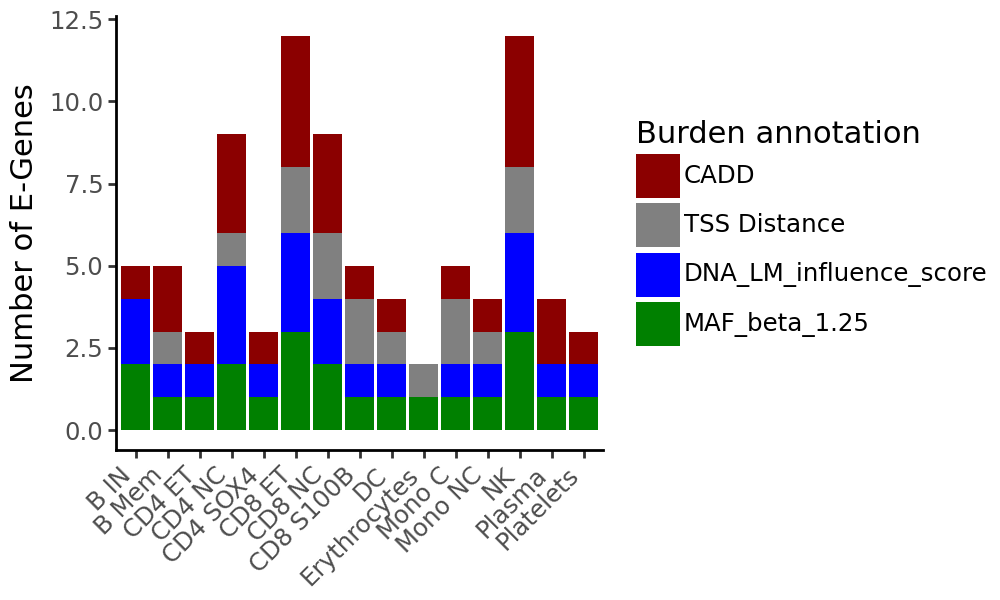

In [17]:
from plotnine import *
plot = (
    ggplot(e_genes_per_cell_type.query("cell_type not in @zero_types"), 
           aes(x='cell_type', y='count'))  # Specify the x and y variables
    + geom_bar(aes(fill = "burden_type"), stat = "identity")  # Add the boxplot layer
    + theme_classic()  # Optional: use a clean theme
    + theme(axis_text_x = element_text(angle = 45, hjust = 1, vjust = 1), figure_size = (5,3)) 
            #legend_position="none")
    + labs(y = "Number of E-Genes", x = "", fill = "Burden annotation")
    + scale_fill_manual(values = ['darkred', "grey", "blue", "green"], labels = ["CADD",  "TSS Distance", "DNA_LM_influence_score", "MAF_beta_1.25"])
)
plot

[2024-12-19 14:05:18,213] INFO:matplotlib.font_manager: Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


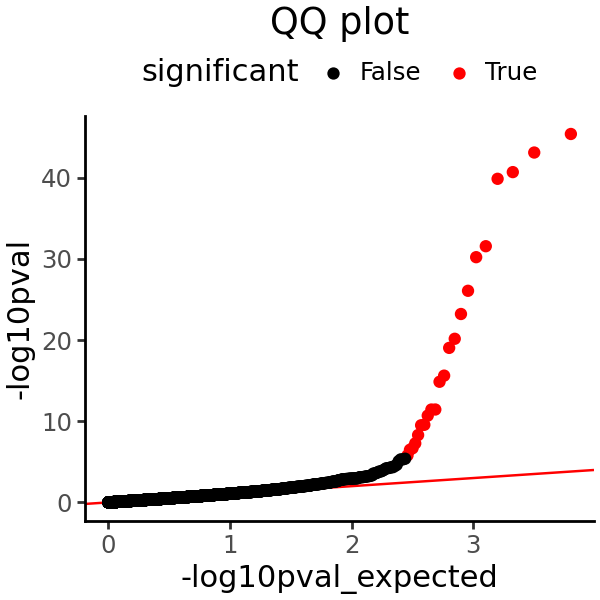

In [18]:
df = all_res.copy().query("burden_type == 'MAF_beta_1.25'")

df = df.sort_values("pvalue")
df["-log10pval_expected"] = -np.log10(np.arange(1, len(df) + 1) / len(df))

if "-log10pval" not in df.columns:
    df["-log10pval"] = -np.log10(df["pvalue"])

aes_kwargs = dict(x="-log10pval_expected", y="-log10pval")
plot = (
    ggplot(df, aes(**aes_kwargs, color="significant"))
    + labs(title="QQ plot")
    + scale_color_manual(values = ["black", "red"])
    + theme_classic()
    + geom_abline(intercept=0, slope=1, color="red")
    + geom_point()
    + theme(legend_position="top", figure_size = (3,3))
)
plot

In [107]:
data.adata.obs.groupby("cell_label").size().sort_values()

/scratch/tmp/l_back/ipykernel_2024435/2387640057.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


cell_label
Erythrocytes       680
Plasma            3625
Platelets         4041
CD4 SOX4          4065
DC                8690
NK R              9677
Mono NC          15166
CD8 S100B        34528
Mono C           38233
B Mem            48023
CD4 ET           61786
B IN             82068
CD8 NC          133482
NK              159820
CD8 ET          205077
CD4 NC          463528
dtype: int64

In [109]:
sig_genes_cd4 = all_res.query("cell_type == 'CD4 NC' & significant")["burden_gene"].unique()
sig_genes_cd4
all_res.query("significant & burden_gene not in @sig_genes_cd4")

burden_gene      target_gene             burden_type        pvalue  \
0  ENSG00000100376  ENSG00000100376                DISTANCE  1.915882e-08   
1  ENSG00000100376  ENSG00000100376              CADD_PHRED  6.576610e-41   
2  ENSG00000100376  ENSG00000100376  DNA_LM_influence_score  2.962627e-47   
3  ENSG00000100376  ENSG00000100376           MAF_beta_1.25  1.970468e-43   
0  ENSG00000075234  ENSG00000075234                DISTANCE  9.409083e-07   
1  ENSG00000075234  ENSG00000075234              CADD_PHRED  4.341488e-07   
2  ENSG00000075234  ENSG00000075234  DNA_LM_influence_score  8.002968e-07   
3  ENSG00000075234  ENSG00000075234           MAF_beta_1.25  6.526352e-07   
0  ENSG00000100376  ENSG00000100376                DISTANCE  6.865553e-09   
1  ENSG00000100376  ENSG00000100376              CADD_PHRED  1.123937e-45   
2  ENSG00000100376  ENSG00000100376  DNA_LM_influence_score  2.123544e-51   
3  ENSG00000100376  ENSG00000100376           MAF_beta_1.25  8.315662e-46   
0  ENSG00000167074  ENSG00000167074                DISTANCE  8.991440e-07   
1  ENSG00000100376  ENSG00000100376              CADD_PHRED  6.344401e-12   
2  ENSG00000100376  ENSG00000100376  DNA_LM_influence_score  2.682561e-14   
3  ENSG00000100376  ENSG00000100376           MAF_beta_1.25  4.022593e-12   
0  ENSG00000128408  ENSG00000128408                DISTANCE  1.666894e-06   
1  ENSG00000100376  ENSG00000100376              CADD_PHRED  1.946241e-22   
2  ENSG00000100376  ENSG00000100376  DNA_LM_influence_score  1.320343e-26   
3  ENSG00000100376  ENSG00000100376           MAF_beta_1.25  5.472479e-24   
0  ENSG00000075234  ENSG00000075234                DISTANCE  1.029877e-35   
1  ENSG00000075234  ENSG00000075234              CADD_PHRED  3.966427e-40   
2  ENSG00000075234  ENSG00000075234  DNA_LM_influence_score  6.726650e-39   
3  ENSG00000075234  ENSG00000075234           MAF_beta_1.25  3.811322e-40   
1  ENSG00000100376  ENSG00000100376              CADD_PHRED  3.670458e-33   
2  ENSG00000100376  ENSG00000100376  DNA_LM_influence_score  1.564509e-35   
3  ENSG00000100376  ENSG00000100376           MAF_beta_1.25  5.442192e-32   
1  ENSG00000100376  ENSG00000100376              CADD_PHRED  4.959931e-45   
2  ENSG00000100376  ENSG00000100376  DNA_LM_influence_score  2.822280e-45   
3  ENSG00000100376  ENSG00000100376           MAF_beta_1.25  2.428840e-41   
0  ENSG00000100376  ENSG00000100376                DISTANCE  2.805409e-08   
1  ENSG00000100376  ENSG00000100376              CADD_PHRED  7.134458e-21   
2  ENSG00000100376  ENSG00000100376  DNA_LM_influence_score  3.121486e-25   
3  ENSG00000100376  ENSG00000100376           MAF_beta_1.25  1.080970e-19   
0  ENSG00000100376  ENSG00000100376                DISTANCE  1.285431e-07   
1  ENSG00000100376  ENSG00000100376              CADD_PHRED  1.228652e-30   
2  ENSG00000100376  ENSG00000100376  DNA_LM_influence_score  7.298681e-29   
3  ENSG00000100376  ENSG00000100376           MAF_beta_1.25  7.443593e-27   
0  ENSG00000188130  ENSG00000188130                DISTANCE  9.151080e-07   
0  ENSG00000100376  ENSG00000100376                DISTANCE  1.176164e-08   
1  ENSG00000100376  ENSG00000100376              CADD_PHRED  2.604993e-31   
2  ENSG00000100376  ENSG00000100376  DNA_LM_influence_score  1.090351e-33   
3  ENSG00000100376  ENSG00000100376           MAF_beta_1.25  1.013244e-30   
1  ENSG00000100376  ENSG00000100376              CADD_PHRED  6.545877e-18   
2  ENSG00000100376  ENSG00000100376  DNA_LM_influence_score  1.145956e-17   
3  ENSG00000100376  ENSG00000100376           MAF_beta_1.25  2.915004e-16   
0  ENSG00000100376  ENSG00000100376                DISTANCE  7.249429e-07   
1  ENSG00000100376  ENSG00000100376              CADD_PHRED  1.145922e-23   
2  ENSG00000100376  ENSG00000100376  DNA_LM_influence_score  4.199012e-25   
3  ENSG00000100376  ENSG00000100376           MAF_beta_1.25  1.094927e-20   
2  ENSG00000100376  ENSG00000100376  DNA_LM_influence_score  1.804196e-06   
1  

In [51]:
gene_oi = "ENSG00000187905"

In [52]:
all_res.query("burden_gene == @gene_oi & burden_type == 'DISTANCE'")

burden_gene      target_gene burden_type    pvalue      beta  \
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.405888  0.000134   
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.334092  0.000146   
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.062503  0.000157   
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.354069 -0.000315   
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.680585  0.000069   
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.340722  0.000207   
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.125368  0.000282   
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.582547 -0.000218   
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.438788  0.000241   
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.231570  0.000304   
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.962260 -0.000039   
0  ENSG00000187905  ENSG00000187905    DISTANCE  0.859557  0.000278   

   cell_type chrom  pvalue_corrected  significant  
0     CD8 ET    22       5129.610406        False  
0     CD8 NC    22       4222.253486        False  
0     CD4 NC    22        789.917530        False  
0     Mono C    22       4474.720849        False  
0         NK    22       8601.237355        False  
0       B IN    22       4306.046887        False  
0     CD4 ET    22       1584.406356        False  
0    Mono NC    22       7362.229396        False  
0  CD8 S100B    22       5545.408614        False  
0      B Mem    22       2926.579449        False  
0         DC    22      12161.042181        False  
0       NK R    22      10863.084997        False

In [60]:
all_res.query("significant").groupby("burden_gene").size().to_frame(name = "Number of Sig. cell types")#.loc[gene_oi]

Number of Sig. cell types
burden_gene                               
ENSG00000075234                          4
ENSG00000099968                          1
ENSG00000100219                          1
ENSG00000100376                         19
ENSG00000128408                          1
ENSG00000167074                          1
ENSG00000184983                          6
ENSG00000188130                          1
ENSG00000212939                          7

In [61]:
this_ddata_mono = compute_pseudobulks(ddata, "Plasma")
this_ddata_cd = compute_pseudobulks(ddata, "CD4 NC")

NameError: name 'compute_pseudobulks' is not defined

In [47]:
y_cd = this_ddata_cd.gdata.obsm["pseudo_mean"][gene_oi] 
y_mono = this_ddata_mono.gdata.obsm["pseudo_mean"][gene_oi]
b = this_ddata_mono.gdata.uns['gene_burdens'].query("Gene == @gene_oi")["CADD_PHRED"]

In [51]:
merged = y_cd.to_frame(name = "CD4 NC").join(y_mono.to_frame(name = "Plasma")).join(b)
merged = merged.reset_index()\
    .melt(id_vars = ["CADD_PHRED", "id"], value_vars = ["CD4 NC","Plasma"], var_name = "Cell type", value_name = "Expression")
merged

CADD_PHRED         id Cell type  Expression
0          9.514        1_1    CD4 NC    0.000924
1          0.000        2_2    CD4 NC    0.000000
2          0.000        3_3    CD4 NC    0.002641
3          0.000        4_4    CD4 NC    0.001961
4          0.000        6_6    CD4 NC    0.000885
...          ...        ...       ...         ...
1957       0.000  1077_1078    Plasma    0.000000
1958       0.000  1078_1079    Plasma    0.000000
1959       0.000  1079_1080    Plasma    0.000000
1960       3.481  1080_1081    Plasma    0.000000
1961       0.000  1081_1082    Plasma    0.000000

[1962 rows x 4 columns]

/opt/modules/i12g/anaconda/envs/eh_scgenetics_v1/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 72 rows containing missing values.


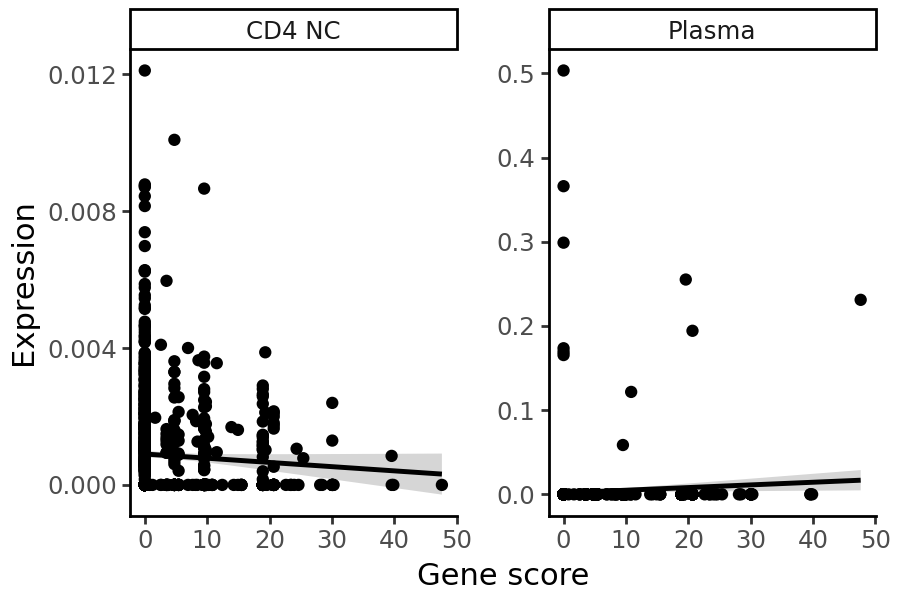

In [58]:
plot = (
    ggplot(merged, aes(x = "CADD_PHRED", y = "Expression"))
    + labs(x = "Gene score")
    + theme_classic()
    + geom_smooth()
    + geom_point()
    + facet_wrap("Cell type", scales = "free")
    + theme(legend_position="top", figure_size = (4.5,3))
)
plot